# ISOM5160 Project - Group7

- **Dataset:** amazon_food_reviews.csv
- **Topic:** AI Driven Personalized Product Improvement Recommendation System for Amazon Sellers
- **Individual Contribution:**

| Name          | SID      | Contributions                                                                                                          |
|---------------|----------|------------------------------------------------------------------------------------------------------------------------|
| CAO, Xi       | 21271664 | Review Text Preprocessing; Sentiment Analysis; Review Keyword Extraction; Data Cleaning                                                                          |
| LI, Heyi      | 21265689 | Anomaly Analysis of Comments and Ratings (Based on Sentiment Analysis of Comments), PPT Coordination                                                                          |
| LIAO, Jingyu  | 21262106 | Analysis of Negative Review Reasons (Based on Review Keywords)                                                                                          |
| LIN, Chuwei   | 21237955 | Time Trend Analysis of Rating                                                                                                          |
| YE, Chenwei   | 21199517 | User Comment Weight Analysis (simple weighted & Bayesian smooth)                                                                                                        |
| ZHANG, Ziyang | 21266920 | 1. Data scraping: additional amazon product info <br/>2. Analyse: Correlation Between Ratings and Product Descriptions |


## 0. Install requirements and do initialization

### 0.1 Install requirements & unzip scrapped data

In [1]:
# Run first to install requirements
!pip install -r requirements.txt > /dev/null

# Run this to speed up the data scraping process
import zipfile

with zipfile.ZipFile("datasets/new_data.zip", "r") as zip_ref:
    zip_ref.extractall("datasets")  # 解压到datasets文件夹里


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### 0.2 Run data cleaning & load `amazon_food_reviews.csv`

In [2]:
from amazon_new_data_scraping import parallel_scrape_amazon_product_info, load_all_data_as_dataframe, \
    extract_comments_from_product_info
from data_cleaning import add_sentiment_score, main as data_cleaning_main
from IPython.core.interactiveshell import InteractiveShell

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists('datasets/amazon_food_reviews_cleaned.csv'):
    data_cleaning_main()

df_amazon_food_reviews = pd.read_csv('datasets/amazon_food_reviews.csv',
                                     converters={"Time": lambda x: pd.to_datetime(int(x), unit="s")})

InteractiveShell.ast_node_interactivity = 'all'

### 0.3 Scrape product info from *amazon.com* & load production info and concat to original dataset

In [3]:
InteractiveShell.ast_node_interactivity = 'last_expr'

product_id_list = list(df_amazon_food_reviews.ProductId.unique())
print(f"Total number of products: {len(product_id_list)}")
print("Start scraping data...")
parallel_scrape_amazon_product_info(product_id_list, replace=False)
print("Scraping finished.")
df_amazon_product_info = load_all_data_as_dataframe()
print("Product info loaded.")

# Optional: Comment it out if not needed in 4.3.3
df_amazon_product_info = add_sentiment_score(df_amazon_product_info, 'product_description')
print("Sentiment score loaded.")

df_amazon_product_info.sample(3)

# Concat new reviews to the original dataset and drop duplicates
df_amazon_food_reviews = pd.concat([df_amazon_food_reviews, extract_comments_from_product_info(df_amazon_product_info)]
                                   ).drop_duplicates(['Score', 'Time', 'Summary']).reset_index(drop=True)

df_amazon_food_reviews.sample(3)

Total number of products: 4322
Start scraping data...
Using 12 CPU cores for parallel scraping


Scraping amazon products: 100%|██████████| 4322/4322 [00:01<00:00, 3780.63it/s]


Successfully scraped 4322/4322 products
Scraping finished.


Loading product info: 100%|██████████| 4322/4322 [00:00<00:00, 12927.62it/s]


Product info loaded.
发现本地缓存模型，从 ./sentiment_model_cache 加载...


Adding sentiment score (using mps): 100%|██████████| 3381/3381 [00:27<00:00, 124.97it/s]

情感分数计算完成
Sentiment score loaded.


,product_id,product_title,byline_info,product_description,category,alt_images,product_detail,important_information,top_comments,CountAltImages,Score,ScoreDistribution,ScorePolarizationIndex,NumRatings,IsFood,sentiment_score
1616,B0006TVP8Q,YC Chocolate (70% Cocoa) Dark with Orange Bits...,Brand: YC Chocolate,YC Chocolatier makes the finest all natural su...,"[Grocery & Gourmet Food, Snacks & Sweets, Choc...",[https://m.media-amazon.com/images/I/41Hi6w5Ez...,{'Package Dimensions': '7.8 x 4.9 x 3.2 inches...,{'Safety Information': 'Manufactured on Machin...,"[{'date': 'January 28, 2014', 'title': 'Not Re...",1,2.8,"[0.0, 73.0, 0.0, 0.0, 27.0]",0.500551,6,True,0.978670
611,B000EXA92M,"SF Signature Dark Chocolate Fondue, 3.5-Pound ...",Brand: SF Signature,SF Signature Dark Chocolate Fondue is absolute...,"[Home & Kitchen, Kitchen & Dining, Cookware, F...",[https://m.media-amazon.com/images/I/51zYjTfmk...,{'Package Dimensions': '10.7 x 6.3 x 6.2 inche...,{'Safety Information': 'This product contains ...,"[{'date': 'April 11, 2007', 'title': 'A lovely...",2,3.8,"[14.0, 0.0, 22.0, 16.0, 48.0]",0.304874,20,False,0.999779
104,B000GPXRS6,NESQUIK Choc Pwdr NSA 6x16oz N1 US,Visit the Nesquik Store,NESQUIK No Sugar Added Chocolate Powder turns ...,"[Grocery & Gourmet Food, Beverages, Bottled Be...",[https://m.media-amazon.com/images/I/51MkrdSj8...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",{'Safety Information': 'This product is labell...,"[{'date': 'August 16, 2025', 'title': 'Snacks ...",5,4.5,"[5.0, 2.0, 6.0, 10.0, 77.0]",0.274873,6232,True,0.997142


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
12037,NaN,B000F7HRL8,NaN,NaN,2,NaN,1,2014-12-07,Not what you'll be getting,What you'll actually be getting...Chocolate ch...
13765,NaN,B000G1X456,NaN,NaN,3,NaN,5,2009-03-10,Great for Strong Coffee lovers--Simply the bes...,"If you like strong coffee, this is it! The fl..."
8169,445577.0,B000DZFMG4,A11K26H5MTNP0C,Jenn of Albion,0,0.0,5,2010-10-15,Good but Crumby,"The cookies are delicious, but they did not su..."


## 1. Negative Review Analysis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading cleaned review data...
Identifying negative reviews...
Identified 1397 negative reviews (Score ≤2 and sentiment score <0.4)
Analyzing negative keywords...
Categorizing negative reasons...
Visualizations saved to datasets
Analysis results saved to datasets

=== Negative Review Analysis Summary ===
Top Negative Reason Categories:
category
other        6725
taste         847
packaging     277
quality       164
Name: frequency, dtype: int64


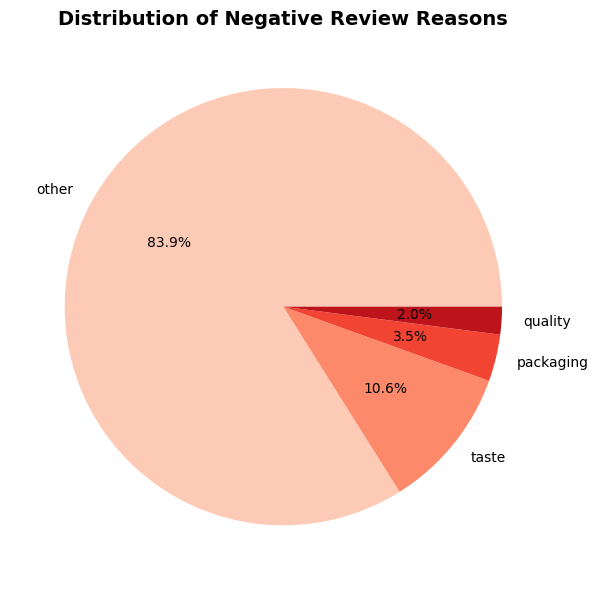

In [4]:
from negative_review_analysis import main as analyse_negative_review
ax1, ax2 = analyse_negative_review()
display(ax1.get_figure())

## 2.Sentiment score outlier analysis

### 2.1 Sentiment outliers

10 of the most mismatched reviews:


,Id,ProductId,Score,sentiment_score_scaled,sentiment_gap,z_score,Summary,Text_cleaned
0,350,B00067AD4U,5,0.006153,4.993847,2.010597,excellent - exactly what I expected,the product was exactly as advertised and fres...
17,544,B000G6RYNE,1,4.695558,-3.695558,-2.528884,USED to be my favorite chips,kettle brand chips used to be so goodoily crun...
42,1161,B000084E1U,5,0.017925,4.982075,2.004447,Cats love it!,i have nine cats and they are crazy about thes...
156,7399,B0002Q1X6C,1,4.750528,-3.750528,-2.557602,"beware, these are tuber indicum, not melanosporum",these are not black winter truffles tuber mela...
170,7786,B000E1BM16,5,0.018361,4.981639,2.004219,Fantastic deal!,for coffee drinkers who buy maxwell house coff...
188,9513,B0005XOJEA,5,0.012049,4.987951,2.007517,my olvatine,ive been buying olvatine for 16 yrs for my 7 c...
204,11278,B000E21Z7Q,2,4.964864,-2.964864,-2.147158,Nutritious but not so delicious.,these pretzels have a nice crunch and a lot of...
250,13970,B000793XK8,5,0.012486,4.987514,2.007289,By far the best truffle oil available,ive read a whole lot of reviews for the variou...
283,15522,B000255OIG,5,0.012627,4.987373,2.007215,Good Product- VERY Slow Super Saver Shipping,my dogs love this product they beg for them th...
386,19563,B000084ETV,1,3.926203,-2.926203,-2.126961,OUR DOG BECAME VIOLENTLY ILL...NOT THE 1st...,we switched or dog to the canned all ages food...


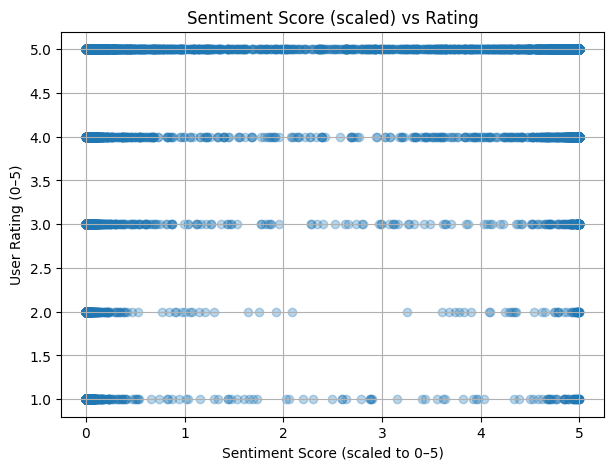

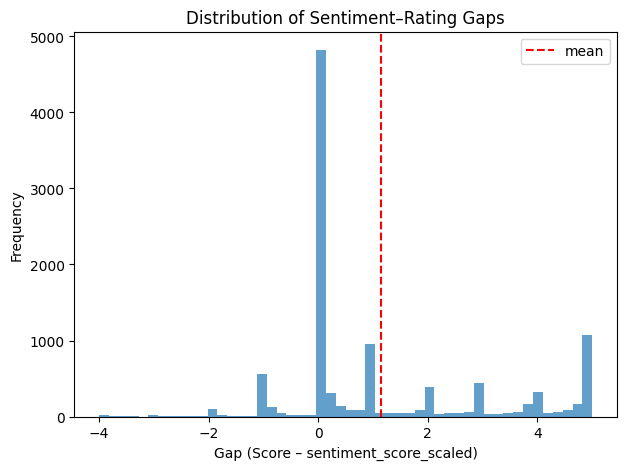

Mean gap: 1.1451932142205015
Std gap: 1.9141843542274186
Number of outliers: 483 / 10819


In [5]:
# 确保 sentiment_score 与 Score 同区间
df_reviews = pd.read_csv('datasets/amazon_food_reviews_cleaned.csv')
df_reviews['sentiment_score_scaled'] = df_reviews['sentiment_score'] * 5

# 计算评论情感与评分的差异
df_reviews['sentiment_gap'] = (
    df_reviews['Score'] - df_reviews['sentiment_score_scaled']
)

# 计算 Z-score，识别异常评论
df_reviews['z_score'] = (
    (df_reviews['sentiment_gap'] - df_reviews['sentiment_gap'].mean())
    / df_reviews['sentiment_gap'].std()
)
df_reviews['is_outlier'] = df_reviews['z_score'].abs() > 2 # |z|>2 视为异常

# 打印异常评论样例
print("10 of the most mismatched reviews:")
display(
    df_reviews.loc[
        df_reviews['is_outlier'],
        ['Id','ProductId', 'Score', 'sentiment_score_scaled', 'sentiment_gap', 'z_score','Summary','Text_cleaned']
    ].head(10)
)

# 绘制散点图：情感分 vs 评分
plt.figure(figsize=(7, 5))
plt.scatter(
    df_reviews['sentiment_score_scaled'],
    df_reviews['Score'],
    alpha=0.3
)
plt.title("Sentiment Score (scaled) vs Rating")
plt.xlabel("Sentiment Score (scaled to 0–5)")
plt.ylabel("User Rating (0–5)")
plt.grid(True)
plt.show()

# 绘制差异分布图
plt.figure(figsize=(7, 5))
plt.hist(df_reviews['sentiment_gap'], bins=50, alpha=0.7)
plt.title("Distribution of Sentiment–Rating Gaps")
plt.xlabel("Gap (Score – sentiment_score_scaled)")
plt.ylabel("Frequency")
plt.axvline(df_reviews['sentiment_gap'].mean(), color='red', linestyle='--', label='mean')
plt.legend()
plt.show()

# 输出统计信息
print("Mean gap:", df_reviews['sentiment_gap'].mean())
print("Std gap:", df_reviews['sentiment_gap'].std())
print(f"Number of outliers: {df_reviews['is_outlier'].sum()} / {len(df_reviews)}")


## 3. Comment Time Series Analysis

In [6]:
reviews_df = df_amazon_food_reviews.copy()

# Ensure datetime: handle both integer seconds and existing datetimes
if not np.issubdtype(reviews_df['Time'].dtype, np.datetime64):
    reviews_df['review_date'] = pd.to_datetime(reviews_df['Time'], unit='s', errors='coerce')
else:
    reviews_df['review_date'] = reviews_df['Time']

# Extract year and month for grouping
reviews_df['year'] = reviews_df['review_date'].dt.year
reviews_df['month'] = reviews_df['review_date'].dt.to_period('M')

### 3.1 Monthly Review Volume Over Time

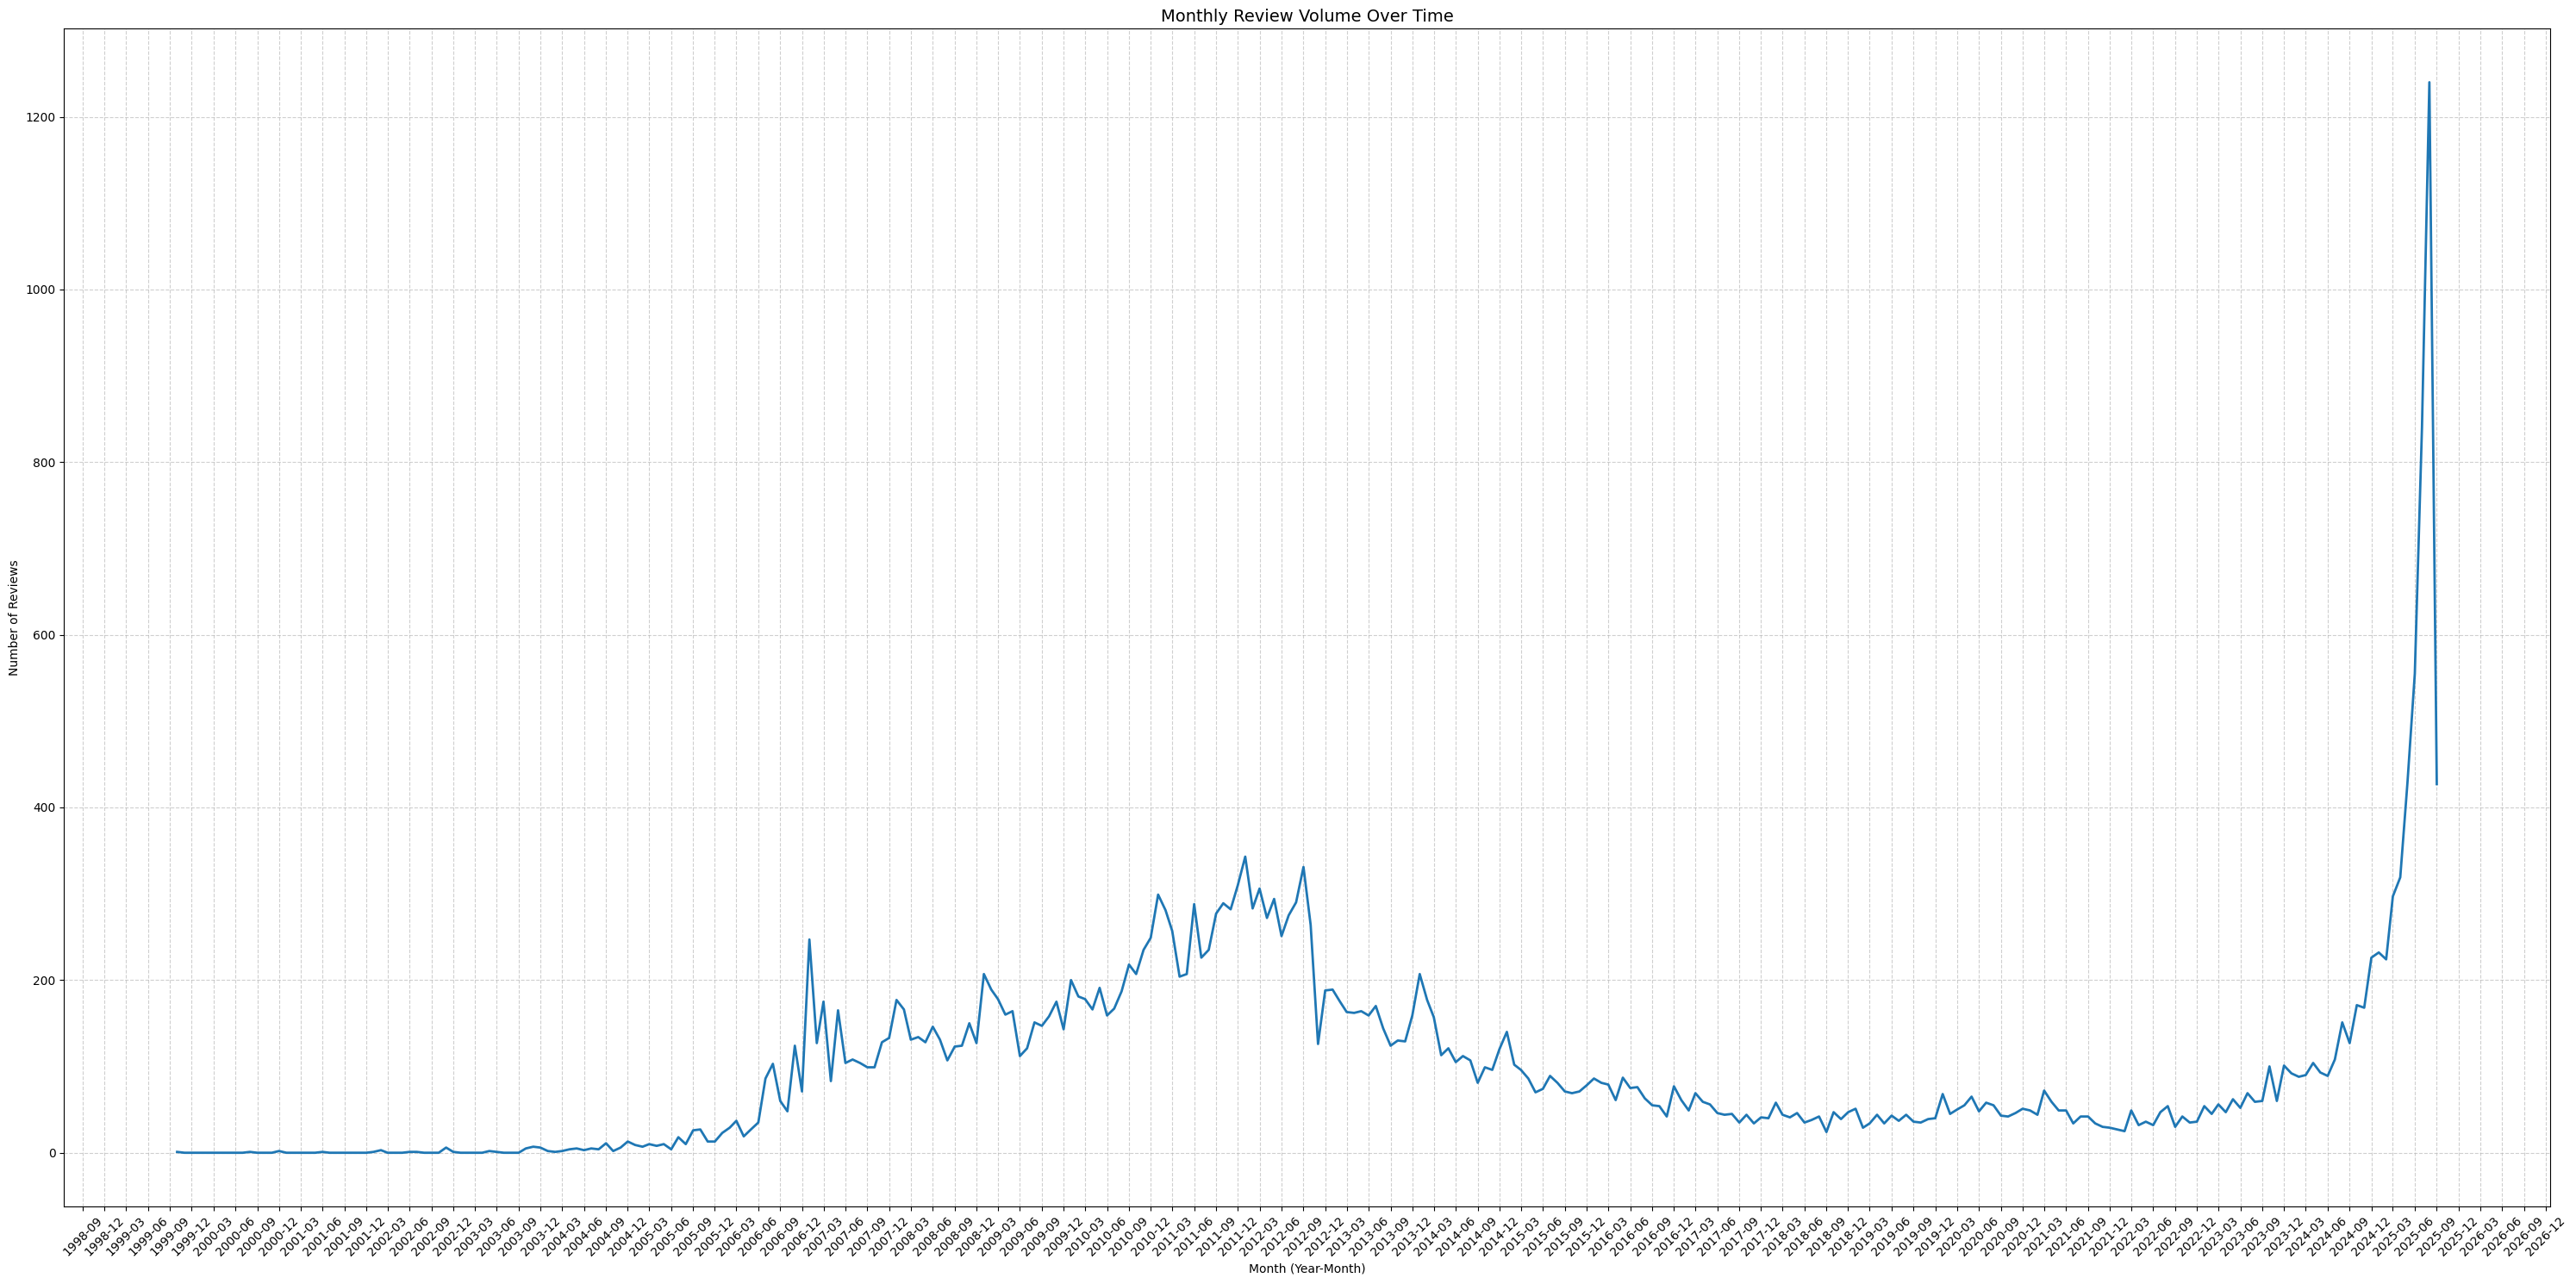

In [7]:
import matplotlib.dates as mdates
import seaborn as sns

# Guard for empty data
if reviews_df.empty or reviews_df['review_date'].isna().all():
    print('No review dates available to plot.')
else:
    # Aggregate counts by month Period
    monthly_series = reviews_df.groupby('month').size()

    # Build continuous monthly index and fill gaps with 0
    month_min = reviews_df['review_date'].dt.to_period('M').min()
    month_max = reviews_df['review_date'].dt.to_period('M').max()
    full_index = pd.period_range(start=month_min, end=month_max, freq='M')
    monthly_series = monthly_series.reindex(full_index, fill_value=0)

    # Prepare DataFrame for plotting
    monthly_reviews = monthly_series.reset_index()
    monthly_reviews.columns = ['month', 'review_count']
    monthly_reviews['month_ts'] = monthly_reviews['month'].dt.to_timestamp()

    plt.figure(figsize=(30,15))
    sns.lineplot(data=monthly_reviews, x='month_ts', y='review_count', color='#1f77b4', linewidth=2)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

    plt.title('Monthly Review Volume Over Time', fontsize=14)
    plt.xlabel('Month (Year-Month)')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

### 3.2 Average Rating Trend Over Time

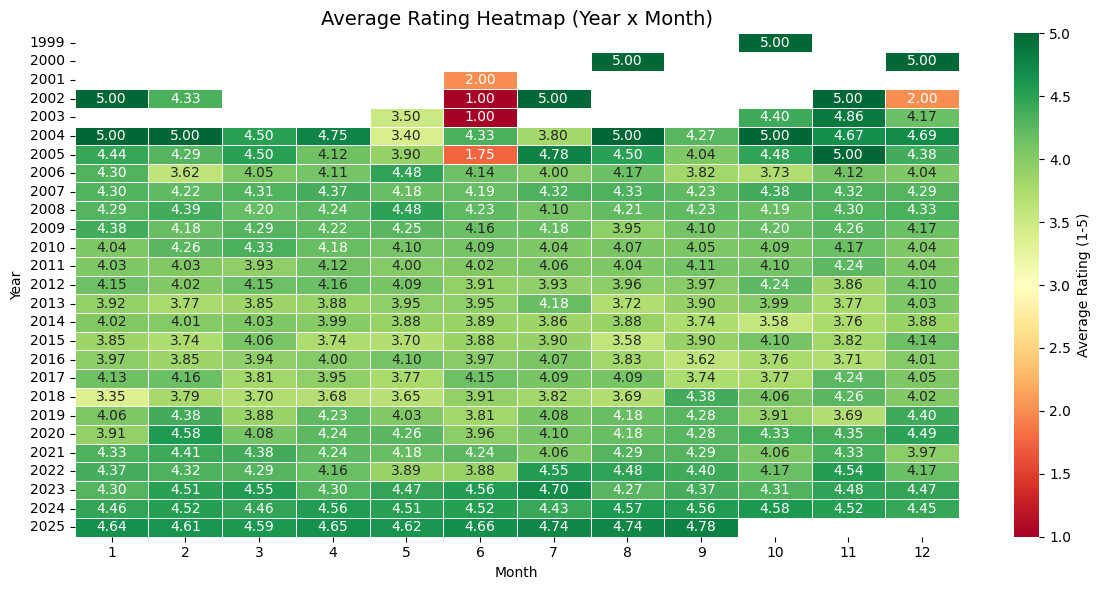

In [8]:
# Rating heatmap: average rating by year x month
# Ensure required columns exist
if 'year' not in reviews_df.columns:
    reviews_df['year'] = reviews_df['review_date'].dt.year
reviews_df['month_num'] = reviews_df['review_date'].dt.month

# Use numeric Score
reviews_df['Score_num'] = pd.to_numeric(reviews_df['Score'], errors='coerce')
valid = reviews_df.dropna(subset=['review_date', 'Score_num']).copy()

if valid.empty:
    print('No valid ratings to build heatmap.')
else:
    rating_heatmap = (valid
        .groupby(['year', 'month_num'])['Score_num']
        .mean()
        .unstack(fill_value=np.nan)
    )
    # Order months 1..12 and years ascending
    month_cols = list(range(1, 13))
    for m in month_cols:
        if m not in rating_heatmap.columns:
            rating_heatmap[m] = np.nan
    rating_heatmap = rating_heatmap[month_cols].sort_index()

    plt.figure(figsize=(12,6))
    sns.heatmap(
        rating_heatmap,
        cmap='RdYlGn',
        vmin=1, vmax=5,
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={'label': 'Average Rating (1-5)'}
    )
    plt.title('Average Rating Heatmap (Year x Month)', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()

### 3.3 Review Count by Year

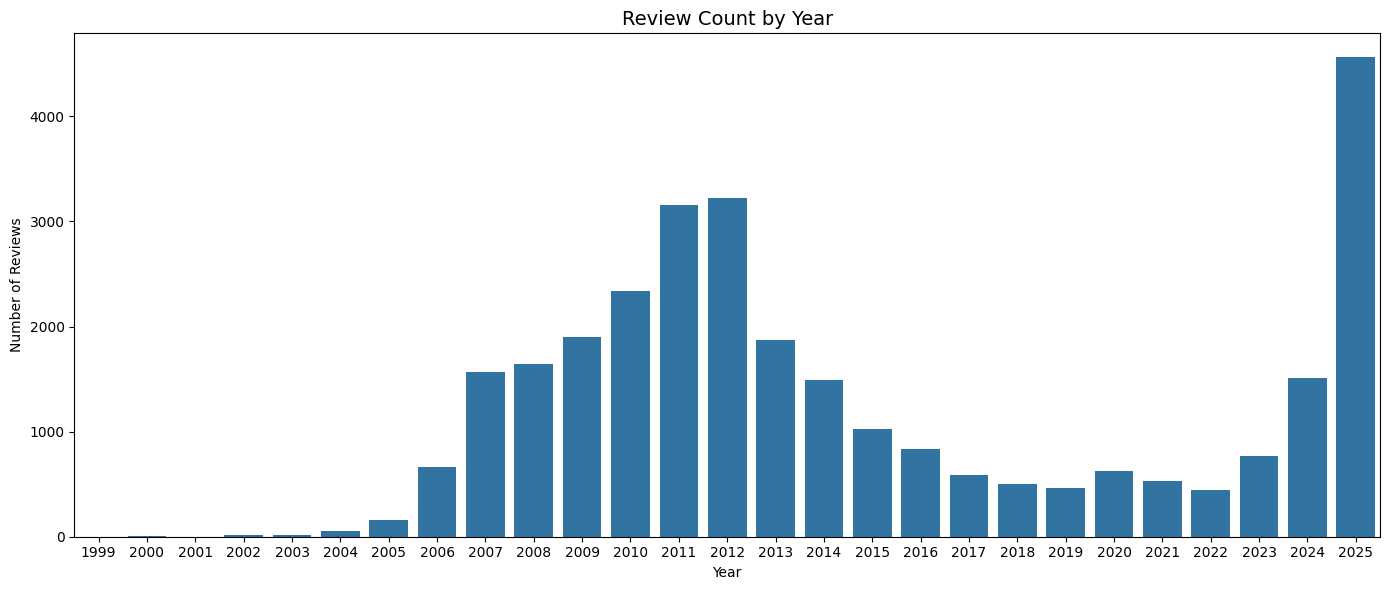

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure review_date and year
if 'review_date' not in reviews_df.columns:
    tmp = df_amazon_food_reviews.copy()
    reviews_df = tmp.copy()
    reviews_df['review_date'] = pd.to_datetime(reviews_df['Time'], errors='coerce', unit='s')
if 'year' not in reviews_df.columns:
    reviews_df['year'] = reviews_df['review_date'].dt.year

valid = reviews_df.dropna(subset=['review_date']).copy()

if valid.empty:
    print('No review dates available to compute yearly counts.')
else:
    year_counts = valid.groupby('year').size().rename('review_count')

    # Fill continuous year range with zeros
    yr_min = int(valid['year'].min())
    yr_max = int(valid['year'].max())
    full_years = pd.Index(range(yr_min, yr_max + 1), name='year')
    year_counts = year_counts.reindex(full_years, fill_value=0)

    plt.figure(figsize=(14,6))
    sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, color='#1f77b4')
    plt.title('Review Count by Year', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


## 3.Review weight analysis

In [10]:
plt.rcdefaults()

# 0 Input & Preparation
cols = ['ProductId', 'Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator']
reviews = df_amazon_food_reviews[cols].copy()

# 1.1 Simple weight: pure Numerator
reviews['weight_simple'] = reviews['HelpfulnessNumerator'].fillna(0).clip(lower=0)
reviews.loc[reviews['weight_simple'] == 0, 'weight_simple'] = 1.0

# 1.2 smoothed weight: Bayesian + log-scale Denominator
a = b = 1.0
r = (reviews['HelpfulnessNumerator'] + a) / (reviews['HelpfulnessDenominator'] + a + b)
t = 1 + np.log1p(reviews['HelpfulnessDenominator'])
reviews['weight_smooth'] = r * t

# Clip weights to avoid extreme values
reviews['weight_smooth'] = reviews['weight_smooth'].clip(lower=0.05, upper=10)

In [11]:
# main aggregation
reviews['wscore_simple'] = reviews['Score'] * reviews['weight_simple']
reviews['wscore_smooth'] = reviews['Score'] * reviews['weight_smooth']

agg_main = (reviews
    .groupby('ProductId', as_index=False)
    .agg(
        mean_score=('Score', 'mean'),               
        num_reviews=('Score', 'size'),
        sum_weight_simple=('weight_simple', 'sum'),
        sum_wscore_simple=('wscore_simple', 'sum'),
        sum_weight_smooth=('weight_smooth', 'sum'),
        sum_wscore_smooth=('wscore_smooth', 'sum'),
    )
)

# 1) calculate weighted mean scores
agg_main['weighted_mean_simple'] = np.where(
    agg_main['sum_weight_simple'] > 0,
    agg_main['sum_wscore_simple'] / agg_main['sum_weight_simple'],
    np.nan
)
agg_main['weighted_mean_smooth'] = np.where(
    agg_main['sum_weight_smooth'] > 0,
    agg_main['sum_wscore_smooth'] / agg_main['sum_weight_smooth'],
    np.nan
)

# 2) bayesian mean scores
global_mean = reviews['Score'].mean()
m = agg_main['sum_weight_smooth'].median()
m = np.nan_to_num(m, nan=0.0)
m = max(m, 1e-6)

agg_main['bayesian_mean_smooth'] = (
    (m * global_mean + agg_main['weighted_mean_smooth'] * agg_main['sum_weight_smooth']) /
    (m + agg_main['sum_weight_smooth'])
)

m_simple = agg_main['sum_weight_simple'].median()
m_simple = np.nan_to_num(m_simple, nan=0.0)
m_simple = max(m_simple, 1e-6)

agg_main['bayesian_mean_simple'] = (
    (m_simple * global_mean + agg_main['weighted_mean_simple'] * agg_main['sum_weight_simple']) /
    (m_simple + agg_main['sum_weight_simple'])
)

# 3) merge score table
score_table = agg_main[['ProductId','mean_score','num_reviews',
                        'weighted_mean_simple','weighted_mean_smooth',
                        'bayesian_mean_smooth','bayesian_mean_simple']].copy()

# 4) merge back to product info
try:
    df_amazon_product_info['product_id'] = df_amazon_product_info['product_id'].astype(str)
except Exception:
    pass
try:
    score_table['ProductId'] = score_table['ProductId'].astype(str)
except Exception:
    pass
_metric_cols = ['mean_score','num_reviews','weighted_mean_simple','weighted_mean_smooth',
                'bayesian_mean_smooth','bayesian_mean_simple']
df_amazon_product_info = df_amazon_product_info.drop(columns=[c for c in _metric_cols if c in df_amazon_product_info.columns], errors='ignore')

df_amazon_product_info = df_amazon_product_info.merge(
    score_table, left_on='product_id', right_on='ProductId', how='left'
)
df_amazon_product_info = df_amazon_product_info.drop(columns=['ProductId'], errors='ignore')

# 5) Applying ScoreDistribution
from ast import literal_eval

def _parse_score_distribution(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    if x is None:
        return [0, 0, 0, 0, 0]
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return [0, 0, 0, 0, 0]
        try:
            return list(literal_eval(s))
        except Exception:
            return [0, 0, 0, 0, 0]
    # Catch NaN and other types
    try:
        if pd.isna(x):
            return [0, 0, 0, 0, 0]
    except Exception:
        pass
    return [0, 0, 0, 0, 0]

_sd = df_amazon_product_info['ScoreDistribution'].apply(_parse_score_distribution).apply(pd.Series)
_sd.columns = ['count_1star','count_2star','count_3star','count_4star','count_5star']
for c in _sd.columns:
    df_amazon_product_info[c] = pd.to_numeric(_sd[c], errors='coerce').fillna(0).astype(int)

# 6) Additional columns
for c in ['mean_score','weighted_mean_simple','weighted_mean_smooth','bayesian_mean_smooth','bayesian_mean_simple']:
    if c in df_amazon_product_info.columns:
        df_amazon_product_info[c] = pd.to_numeric(df_amazon_product_info[c], errors='coerce')

df_amazon_product_info['diff_smooth_vs_simple'] = (
    df_amazon_product_info['weighted_mean_smooth'] - df_amazon_product_info['weighted_mean_simple']
)
df_amazon_product_info['diff_bayes_vs_mean'] = (
    df_amazon_product_info['bayesian_mean_smooth'] - df_amazon_product_info['mean_score']
)

# 7) Show sample
cols_show = [
    'product_id','num_reviews','mean_score',
    'weighted_mean_simple','weighted_mean_smooth','bayesian_mean_smooth',
    'diff_smooth_vs_simple','diff_bayes_vs_mean',
    'count_1star','count_2star','count_3star','count_4star','count_5star'
]
df_amazon_product_info[cols_show].head(10)

,product_id,num_reviews,mean_score,weighted_mean_simple,weighted_mean_smooth,bayesian_mean_smooth,diff_smooth_vs_simple,diff_bayes_vs_mean,count_1star,count_2star,count_3star,count_4star,count_5star
0,B0007GFDP4,5.0,3.800000,4.000000,5.000000,4.396717,1.000000,0.596717,20,0,19,0,61
1,B000EMEEHE,10.0,3.400000,3.583333,3.139252,3.626380,-0.444082,0.226380,23,9,27,9,32
2,B000E671W0,9.0,4.888889,4.666667,5.000000,4.396717,0.333333,-0.492171,2,1,2,7,88
3,B000084E76,8.0,2.875000,2.893617,2.000000,3.284147,-0.893617,0.409147,26,12,12,13,37
4,B0009TQC90,9.0,3.444444,3.666667,5.000000,4.396717,1.333333,0.952273,10,20,32,10,28
5,B000FPGYTQ,14.0,4.500000,4.533333,3.605579,3.769622,-0.927754,-0.730378,0,0,3,7,90
6,B0000CDBRK,9.0,4.888889,4.916667,5.000000,4.666217,0.083333,-0.222672,1,0,2,7,90
7,B000FOYMIC,10.0,3.600000,2.600000,3.000000,3.736894,0.400000,0.136894,15,7,17,11,50
8,B0002IF5CI,9.0,3.888889,3.500000,5.000000,4.685869,1.500000,0.796980,13,42,14,14,17
9,B0000D9MT1,9.0,3.888889,3.666667,5.000000,4.537066,1.333333,0.648177,8,8,10,9,65


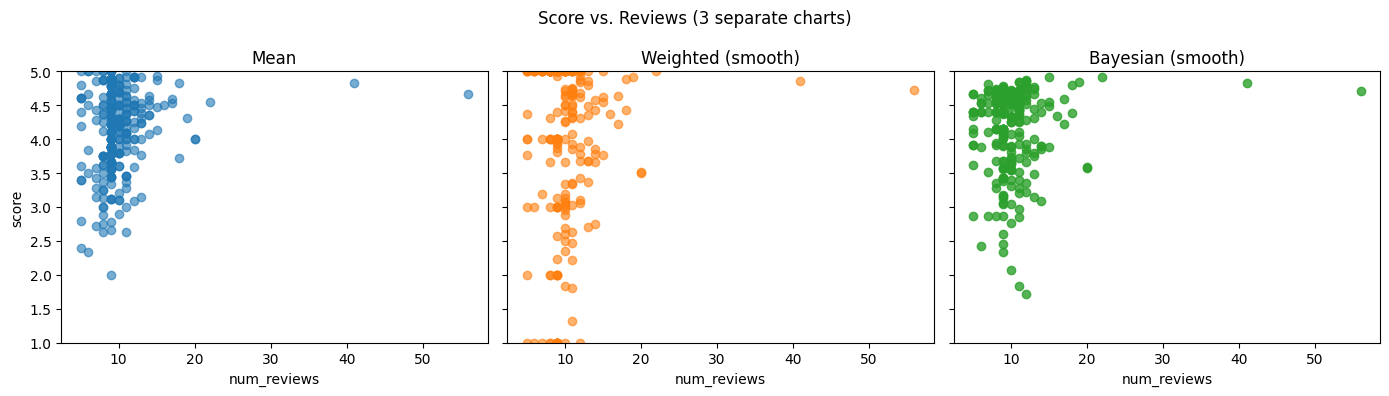

,product_id,num_reviews,mean_score,weighted_mean_simple,weighted_mean_smooth,bayesian_mean_smooth
47,B00068R7W0,1.0,1.0,1.0,1.0,3.359143


,product_id,num_reviews,mean_score,weighted_mean_simple,weighted_mean_smooth,bayesian_mean_smooth
49,B000EVIDUY,22.0,4.545455,4.72973,5.0,4.909562


In [12]:
# visualization
req_cols = ['num_reviews','mean_score','weighted_mean_smooth','bayesian_mean_smooth']
sample_base = df_amazon_product_info.dropna(subset=[c for c in req_cols if c in df_amazon_product_info.columns])
sample = (sample_base
          .query('num_reviews>=5')
          .sample(min(300, len(sample_base)), random_state=42) if len(sample_base) > 0 else sample_base)

fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=True, sharey=True)
axes[0].scatter(sample['num_reviews'], sample['mean_score'], color='C0', alpha=0.6)
axes[0].set_title('Mean')
axes[1].scatter(sample['num_reviews'], sample['weighted_mean_smooth'], color='C1', alpha=0.6)
axes[1].set_title('Weighted (smooth)')
axes[2].scatter(sample['num_reviews'], sample['bayesian_mean_smooth'], color='C2', alpha=0.8)
axes[2].set_title('Bayesian (smooth)')
for ax in axes:
    ax.set_xlabel('num_reviews')
axes[0].set_ylabel('score')
axes[0].set_ylim(1,5)
plt.suptitle('Score vs. Reviews (3 separate charts)')
plt.tight_layout()
plt.show()

# two examples
one_review = df_amazon_product_info.query('num_reviews==1').head(1)
sort_key = 'weighted_mean_smooth' if 'weighted_mean_smooth' in df_amazon_product_info.columns else 'num_reviews'
many_reviews = (df_amazon_product_info.query('num_reviews>=20')
                .sort_values(sort_key, ascending=False)
                .head(1))
display(one_review[cols_show[:6]])
display(many_reviews[cols_show[:6]])

## 4. Correlation Between Ratings and Product Descriptions

### 4.1 Rating features
1. Mean Score: The score displayed on the product detail page.
    - Good Score: >= 4.5
2. Score Polarization: Indicates whether the ratings for this product are polarized.
    - Good Polarization: <= 0.25



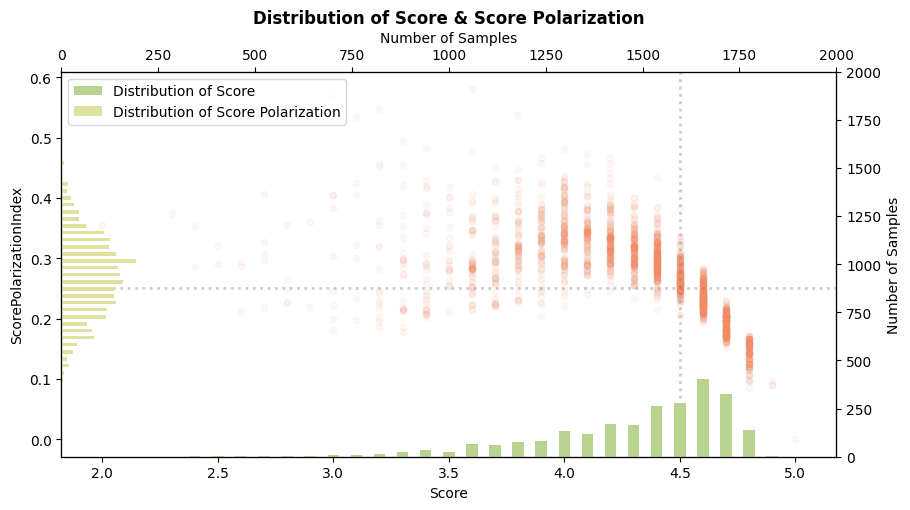

In [13]:
from correlation_with_description_analyse import *
plt.rcdefaults()

draw_product_score_distribution(df_amazon_product_info);

### 4.2 Visual Information Correlation

#### 4.2.1 Correlation with the number of sample images

- A statistical analysis was conducted on the relationship between the number of images in product descriptions and their ratings.
- The line chart illustrates how the proportion of positive reviews and the proportion of low-polarity ratings change with the number of images.

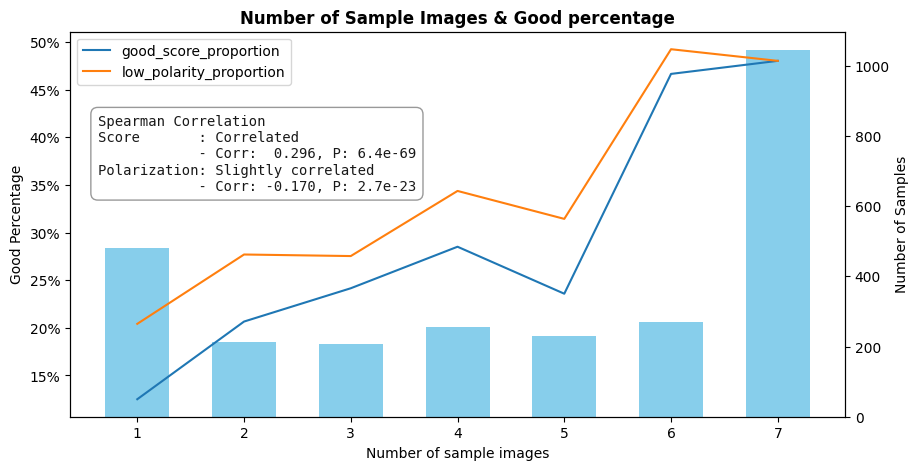

In [14]:
draw_correlation_with_n_images(df_amazon_product_info);

**Conclusion:** The number of images in product ratings and descriptions **<u>correlates positively</u>**. The more images included in the description, the greater the likelihood of the product receiving positive reviews.


### 4.3 Text Information Correlation

- **We use spearmanr to compute Correlation**
- **We analyse text information in 4 aspects**
    1. Correlation with description length
    2. Correlation with reading ease
    3. Correlation with the marketing tone of the description
    4. Correlation with product description items

#### 4.3.1 Correlation with description length


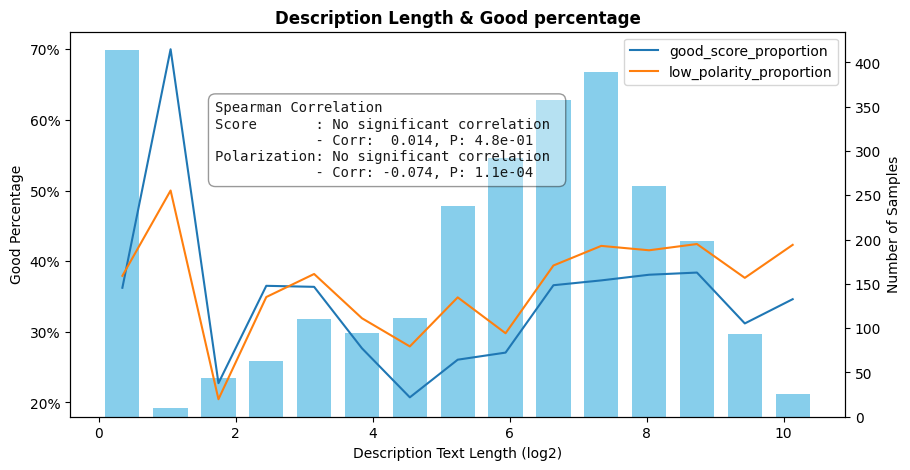

In [15]:
draw_correlation_with_description_length(df_amazon_product_info);

**Conclusion: There is <u>no significant correlation</u> between product ratings and the length of product descriptions.**



#### 4.3.2 Correlation with reading ease

**Types of reading ease:**
1. **flesch reading ease**: The higher the score, the easier it is to read.
2. **flesch kincaid grade**: The required grade level to read; The higher the number, the more difficult the reading level.
3. **gunning fog**: Long word ratio; The higher the ratio, the harder it is to understand.


,ease_index,compare_with,corr,p_value,conclusion
0,flesch_reading_ease,Score,0.016324,0.386284,No significant correlation
1,flesch_reading_ease,ScorePolarizationIndex,-0.018683,0.321381,No significant correlation
2,flesch_kincaid_grade,Score,0.012311,0.513501,No significant correlation
3,flesch_kincaid_grade,ScorePolarizationIndex,-0.013007,0.489990,No significant correlation
4,gunning_fog,Score,0.006578,0.727030,No significant correlation
5,gunning_fog,ScorePolarizationIndex,-0.007591,0.687042,No significant correlation


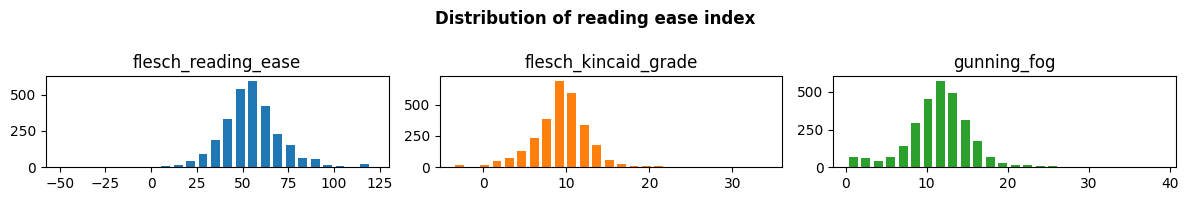

In [16]:
fig, df = get_correlation_with_reading_ease(df_amazon_product_info);
df

**Conclusion: Product ratings show <u>no significant correlation</u> with reading difficulty.**

#### 4.3.3 Correlation with the marketing tone of the description

**Types of marketing tone:**
1. **marketing tone score**: The proportion of exaggerated marketing language in product descriptions. The higher the score, the more exaggerated the marketing claims become.
2. **sentiment score by language model**: model name is `distilbert-base-uncased-finetuned-sst-2-english`, The higher the score, the more positive the emotion.


,sentiment_type,compare_with,corr,p_value,conclusion
1,marketing_tone_score,Score,0.058842,0.000651,No significant correlation
3,marketing_tone_score,ScorePolarizationIndex,-0.046915,0.006578,No significant correlation
0,sentiment_score,Score,0.078782,0.000005,No significant correlation
2,sentiment_score,ScorePolarizationIndex,-0.056808,0.000997,No significant correlation


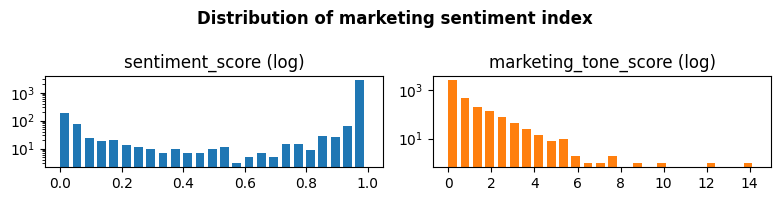

In [17]:
fig, df = get_correlation_with_marketing_sentiment(df_amazon_product_info)
df

**Conclusion:**
- Product ratings show <u>no significant correlation</u> with marketing tone/sentiment.
- However, since the metrics used to measure the emotional orientation of product descriptions do **not follow a normal distribution, <u>conclusions drawn from this basis may be unreliable</u>.**


#### 4.3.4 Correlation with product description items

> For this type of correlation where multiple labels correspond to a single value, regression models or correlation matrices could also be employed.
> However, to maintain consistency with previous implementations, we still use the Spearman method here.


6 of 18 items are correlated with Score/ScorePolarization


,item,compare_with,corr,p_value,conclusion
10,Best Sellers Rank,Score,0.380897,2.900556e-116,Highly correlated
30,Directions,Score,0.221054,2.120214e-38,Correlated
8,Item model number,Score,0.272143,4.947027e-58,Correlated
16,Package Dimensions,Score,-0.247264,6.662581e-48,Correlated
17,Package Dimensions,ScorePolarizationIndex,0.171696,1.319051e-23,Slightly correlated
14,Product Dimensions,Score,0.271464,9.670107e-58,Correlated
32,Safety Information,Score,0.161844,4.034171e-21,Slightly correlated


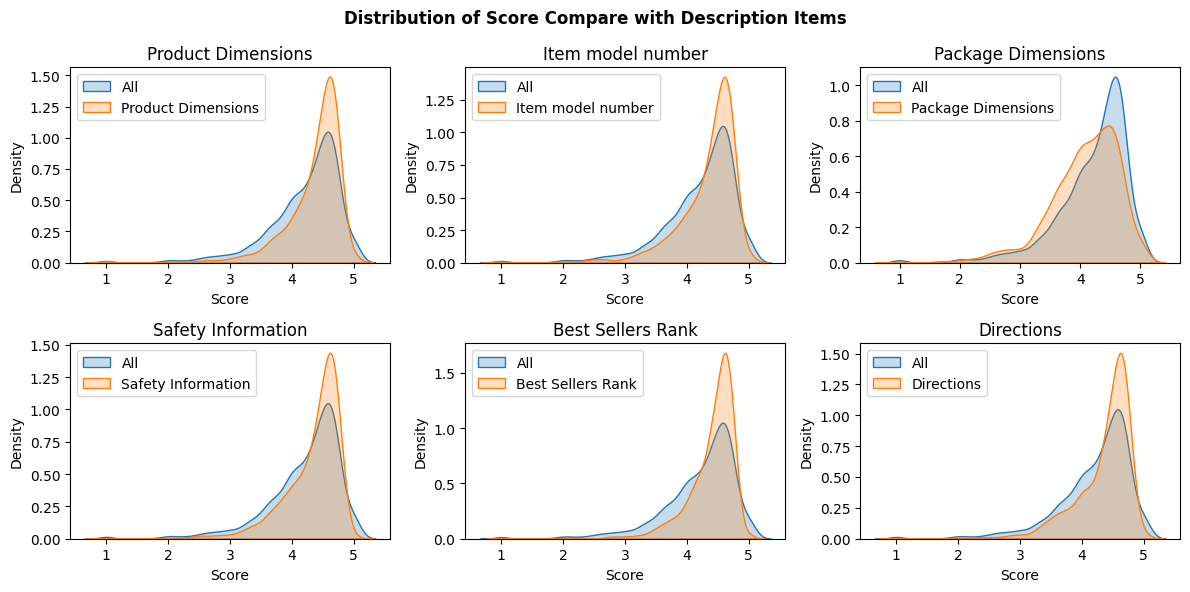

In [18]:
fig, df = get_correlation_with_description_item(df_amazon_product_info)
all_items = df['item'].unique()
df = df[df.conclusion != "No significant correlation"].drop(columns=["category", "num_samples"])
correlated_items = df['item'].unique()
print(f'{len(correlated_items)} of {len(all_items)} items are correlated with Score/ScorePolarization')
df

Conclusion:
1. Products with the following description items might have a better rating:
    - **Best Sellers Rank:** Only high-quality goods carry this label.
    - **Item model number:** Products with model numbers may be more formal and reliable.
    - **Product Dimensions:** Products with Product Dimensions may be more formal and reliable.
    - **Directions:** Products accompanied by directions may reduce negative reviews caused by users' inability to use or misuse the product.
    - **Safety Information:** Products with safety information may reduce negative reviews caused by user allergies.

2. Products with the following description items might have a lower rating:
    - **Package Dimensions:** Products with package dimensions may receive negative reviews due to logistics-related issues.

#### 4.3.5 Conclusion for Product Descriptions

|                   | For Sellers                                                                                                                | For Buyers                                                                                                                 |
|-------------------|----------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| Image             | Increase the number of product images                                                                                      | Choose products with more pictures                                                                                         |
| Descriptions Text | 1. Make product descriptions as professional as possible;<br>2. Provide more detailed safety information and instructions; | 1. Choose products that appear more professional;<br>2. Carefully read the product descriptions to avoid potential issues; |
|                   |                                                                                                                            |                                                                                                                            |